In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cartopy
import xarray as xa

In [2]:
slp_anomaly = xa.open_dataarray('../Composites/daily_slp_stand_anomaly.nc')
z500_anomaly = xa.open_dataarray('../Composites/daily_z500_stand_anomaly.nc')
ivt_a_anomaly = xa.open_dataarray('../Composites/daily_ivt_a_stand_anomaly.nc')
ivt_b_anomaly = xa.open_dataarray('../Composites/daily_ivt_b_stand_anomaly.nc')
ivt_N_anomaly = xa.open_dataarray('../Composites/daily_ivt_N_stand_anomaly.nc')
ivt_E_anomaly = xa.open_dataarray('../Composites/daily_ivt_E_stand_anomaly.nc')
tcwv_anomaly = xa.open_dataarray('../Composites/daily_tcwv_stand_anomaly.nc')
pv200_anomaly = xa.open_dataarray('../Composites/daily_pv200_stand_anomaly.nc')
q850_anomaly = xa.open_dataarray('../Composites/daily_q850_stand_anomaly.nc')

w500_anomaly = xa.open_dataarray('../Composites/daily_w500_std_anomaly.nc')
cape_anomaly = xa.open_dataarray('../Composites/daily_cape_std_anomaly.nc')

In [3]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

In [4]:
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import scipy.stats

def plot_composites(sub_id, time, field, fig, ax, title, rolling=None, vmax=None):
    field_sel = field.sel(time=time)
    mean = field_sel.mean(dim='time')
    std = field_sel.std(dim='time')
    t_statistic = mean/(std/np.sqrt(mean.shape[0]))
    t_flatten = t_statistic.data.reshape(-1)
    crit1 = scipy.stats.norm.ppf(1-0.05/2)
    ind = np.where((t_flatten>-crit1)&(t_flatten<crit1))[0]
    plot_mean = mean.data.copy()
    plot_mean_flatten = plot_mean.reshape(-1)
    plot_mean_flatten[ind]=np.nan
    plot_mean = plot_mean_flatten.reshape(t_statistic.shape)
    if vmax is None:
        vmin = np.nanmin(plot_mean)
        vmax = np.nanmax(plot_mean)
        vmax = np.max([np.abs(vmin), vmax])
    norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    ax.contourf(mean.longitude, mean.latitude, plot_mean, levels=50, norm=norm, cmap='coolwarm')
    if rolling is None:
        ax.contour(mean.longitude, mean.latitude, t_statistic, levels=[-crit1, crit1], colors='black')
    else:
        t_smooth = t_statistic.rolling(latitude=10, center=True).mean().dropna("latitude")
        t_smooth = t_smooth.rolling(longitude=10, center=True).mean().dropna("longitude")
        ax.contour(t_smooth.longitude, t_smooth.latitude, t_smooth, levels=[-crit1, crit1], colors='black')
    # ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
    ax.set_title(title)
    
    fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(sub_id)+".shp"
    shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
    ax.add_feature(shape_feature)

In [5]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
def add_latlon(ax, top, left, bottom, right):
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top
    gl.left_labels = left
    gl.right_labels = right
    gl.bottom_labels=bottom
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
    gl.xlocator = mticker.FixedLocator([-140, -120, -100, -80])

# Sub5

In [6]:
sub_id = 5
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')

In [7]:
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
midtro_days = np.where(midtro_sub>0)[0]
midtro_days = sub_precip.time.data[midtro_days]
midtro_front_days = list(set(midtro_days).intersection(set(front_days)))

In [8]:
front_w_midtro_days = list(set(front_days).intersection(set(midtro_days)))
front_wo_midtro_days = list(set(front_days).difference(set(midtro_days)))

In [9]:
print(len(front_w_midtro_days))
print(len(front_wo_midtro_days))

43
756


In [10]:
print(len(front_days))
print(len(midtro_days))
print(len(midtro_front_days))

799
196
43


In [11]:
tcwv = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/tcwv_all.nc')
tcwv = tcwv.resample(time='1D').first()
w500 = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/1979-2018_w500_all.nc')
w500 = w500.resample(time='1D').first()
ivt_a = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_a_1979_2019')
ivt_a = ivt_a.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_a = ivt_a.resample(time='1D').first()
ivt_b = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_b_1979_2019')
ivt_b = ivt_b.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_b = ivt_b.resample(time='1D').first()

In [12]:
ivt_E = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_E_1979_2019')
ivt_N = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_N_1979_2019')
ivt_E = ivt_E.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_E = ivt_E.resample(time='1D').first()
ivt_N = ivt_N.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_N = ivt_N.resample(time='1D').first()

## Front w/wo midtro

<xarray.DataArray 'TCWV' ()>
array(59.24271, dtype=float32)


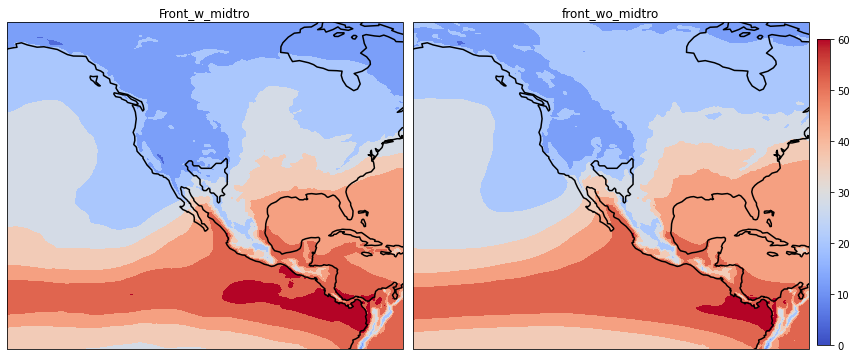

In [15]:
tcwv_front_w_midtro = tcwv.sel(time=front_w_midtro_days).mean(dim='time')
tcwv_front_wo_midtro = tcwv.sel(time=front_wo_midtro_days).mean(dim='time')
print(np.max(tcwv_front_wo_midtro))
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(5)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.Normalize(vmin=0, vmax=60)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front_w_midtro.longitude, tcwv_front_w_midtro.latitude, tcwv_front_w_midtro, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Front_w_midtro')
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front_wo_midtro.longitude, tcwv_front_wo_midtro.latitude, tcwv_front_wo_midtro, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('front_wo_midtro')
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

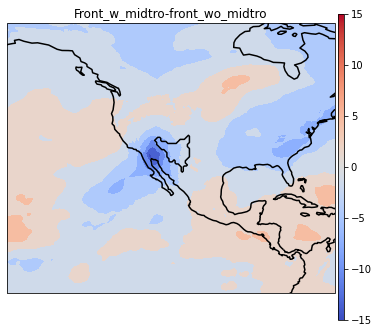

In [17]:
norm = colors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=15)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front_w_midtro.longitude, tcwv_front_w_midtro.latitude, tcwv_front_w_midtro-tcwv_front_wo_midtro, 
            transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Front_w_midtro-front_wo_midtro')
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

<xarray.DataArray ()>
array(1.0675538, dtype=float32) <xarray.DataArray ()>
array(-1.7398235, dtype=float32)
<xarray.DataArray ()>
array(0.1942313, dtype=float32) <xarray.DataArray ()>
array(-0.26919636, dtype=float32)


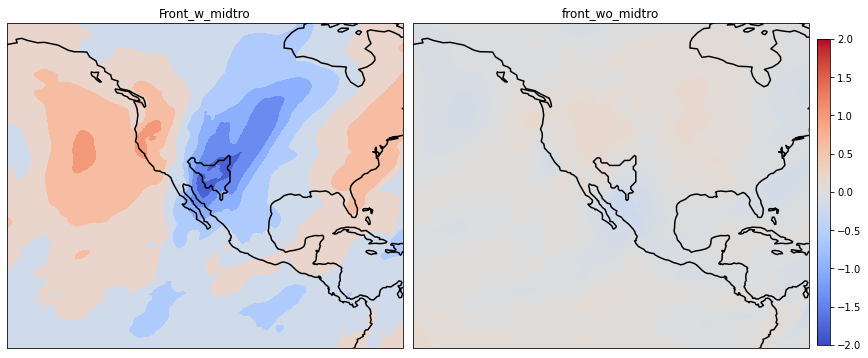

In [26]:
ivtb_front_w_midtro = ivt_b_anomaly.sel(time=front_w_midtro_days).mean(dim='time')
ivtb_front_wo_midtro = ivt_b_anomaly.sel(time=front_wo_midtro_days).mean(dim='time')
print(np.max(ivtb_front_w_midtro), np.min(ivtb_front_w_midtro))
print(np.max(ivtb_front_wo_midtro), np.min(ivtb_front_wo_midtro))
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(5)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.contourf(ivtb_front_w_midtro.longitude, ivtb_front_w_midtro.latitude, ivtb_front_w_midtro, 
            transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Front_w_midtro')
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.contourf(ivtb_front_wo_midtro.longitude, ivtb_front_wo_midtro.latitude, ivtb_front_wo_midtro, 
            transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('front_wo_midtro')
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

<xarray.DataArray ()>
array(1.0675538, dtype=float32) <xarray.DataArray ()>
array(-1.7398235, dtype=float32)
<xarray.DataArray 'W' ()>
array(0.23950063, dtype=float32)
Coordinates:
    level    float64 ... <xarray.DataArray 'W' ()>
array(-0.34526405, dtype=float32)
Coordinates:
    level    float64 ...


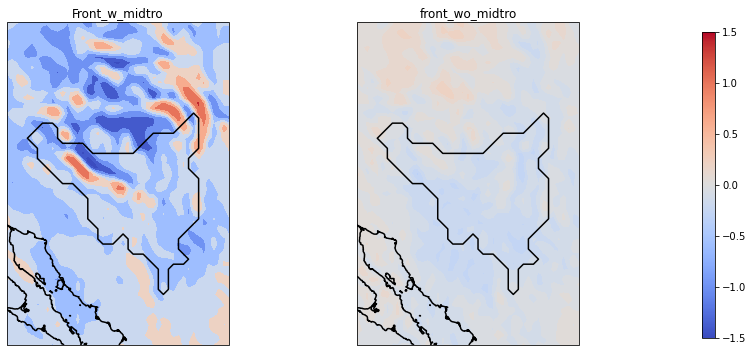

In [32]:
w500_front_w_midtro = w500_anomaly.sel(time=front_w_midtro_days).mean(dim='time')
w500_front_wo_midtro = w500_anomaly.sel(time=front_wo_midtro_days).mean(dim='time')
print(np.max(ivtb_front_w_midtro), np.min(ivtb_front_w_midtro))
print(np.max(w500_front_wo_midtro), np.min(w500_front_wo_midtro))
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(5)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_front_w_midtro.longitude, w500_front_w_midtro.latitude, w500_front_w_midtro, 
            transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax.set_title('Front_w_midtro')
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_front_wo_midtro.longitude, w500_front_wo_midtro.latitude, w500_front_wo_midtro, 
            transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax.set_title('front_wo_midtro')
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

In [27]:
w500_front = w500.sel(time=front_days).mean(dim='time')
w500_midtro = w500.sel(time=midtro_days).mean(dim='time')
w500_midtro_front = w500.sel(time=midtro_front_days).mean(dim='time')
print(np.max(w500_front.data))
print(np.min(w500_front.data))

0.5900687
-1.0442632


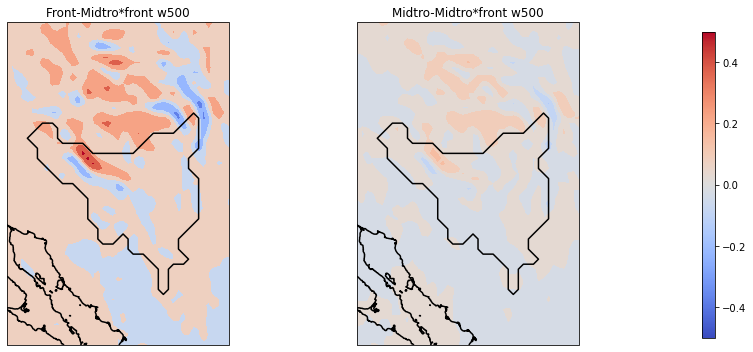

In [28]:
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(5)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.TwoSlopeNorm(vmin=-.5, vcenter=0, vmax=.5)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_front-w500_midtro_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Front-Midtro*front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_midtro-w500_midtro_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro-Midtro*front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

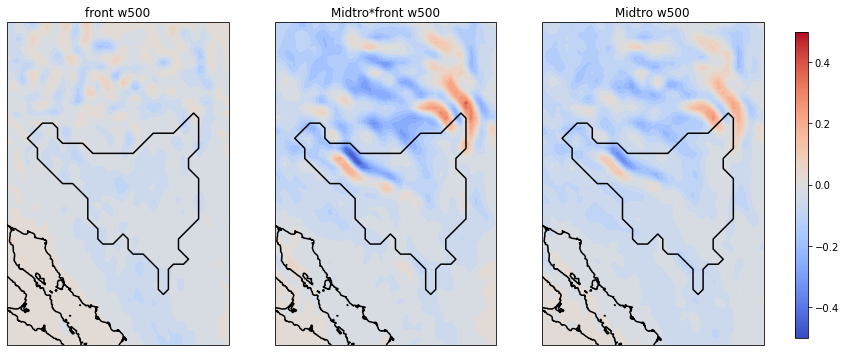

In [29]:
fig = plt.figure(figsize=(12, 5))
norm = colors.TwoSlopeNorm(vmin=-.5, vcenter=0, vmax=.5)
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm", levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_midtro_front, transform=cartopy.crs.PlateCarree(), cmap="coolwarm", norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro*front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_midtro, transform=cartopy.crs.PlateCarree(), cmap="coolwarm", norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

In [30]:
print(len(midtro_days))
print(len(midtro_front_days))

196
43


# Sub4

In [49]:
sub_id = 4
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')

In [50]:
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
midtro_days = np.where(midtro_sub>0)[0]
midtro_days = sub_precip.time.data[midtro_days]
midtro_front_days = list(set(midtro_days).intersection(set(front_days)))
print(len(front_days))
print(len(midtro_days))
print(len(midtro_front_days))

548
234
70


In [51]:
midtro_wo_front = list(set(midtro_days).difference(set(front_days)))
print(sorted(midtro_wo_front))

[numpy.datetime64('1979-06-08T00:00:00.000000000'), numpy.datetime64('1979-06-09T00:00:00.000000000'), numpy.datetime64('1979-08-13T00:00:00.000000000'), numpy.datetime64('1979-08-14T00:00:00.000000000'), numpy.datetime64('1980-09-08T00:00:00.000000000'), numpy.datetime64('1980-09-09T00:00:00.000000000'), numpy.datetime64('1982-07-01T00:00:00.000000000'), numpy.datetime64('1982-09-11T00:00:00.000000000'), numpy.datetime64('1982-09-12T00:00:00.000000000'), numpy.datetime64('1982-09-13T00:00:00.000000000'), numpy.datetime64('1982-09-14T00:00:00.000000000'), numpy.datetime64('1982-09-27T00:00:00.000000000'), numpy.datetime64('1982-09-28T00:00:00.000000000'), numpy.datetime64('1982-09-29T00:00:00.000000000'), numpy.datetime64('1982-09-30T00:00:00.000000000'), numpy.datetime64('1983-06-12T00:00:00.000000000'), numpy.datetime64('1983-06-13T00:00:00.000000000'), numpy.datetime64('1983-06-26T00:00:00.000000000'), numpy.datetime64('1983-07-10T00:00:00.000000000'), numpy.datetime64('1983-09-29T0

<xarray.DataArray 'TCWV' ()>
array(59.300056, dtype=float32)


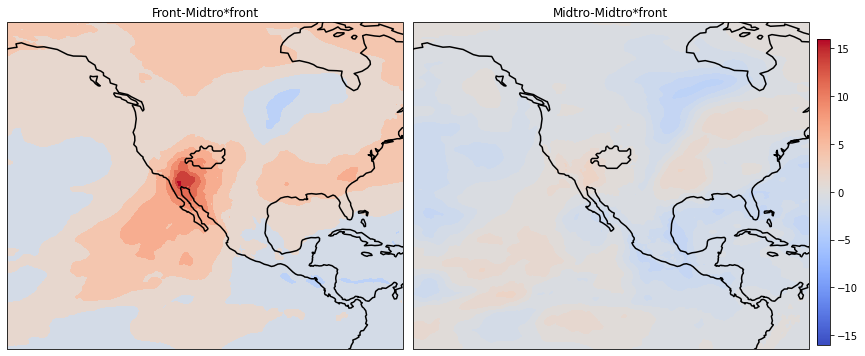

In [33]:
tcwv_front = tcwv.sel(time=front_days).mean(dim='time')
tcwv_midtro = tcwv.sel(time=midtro_days).mean(dim='time')
tcwv_midtro_front = tcwv.sel(time=midtro_front_days).mean(dim='time')
print(np.max(tcwv_front))
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(4)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.TwoSlopeNorm(vmin=-16, vcenter=0, vmax=16)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front.longitude, tcwv_front.latitude, tcwv_front-tcwv_midtro_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Front-Midtro*front')
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front.longitude, tcwv_midtro_front.latitude, tcwv_midtro-tcwv_midtro_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro-Midtro*front')
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

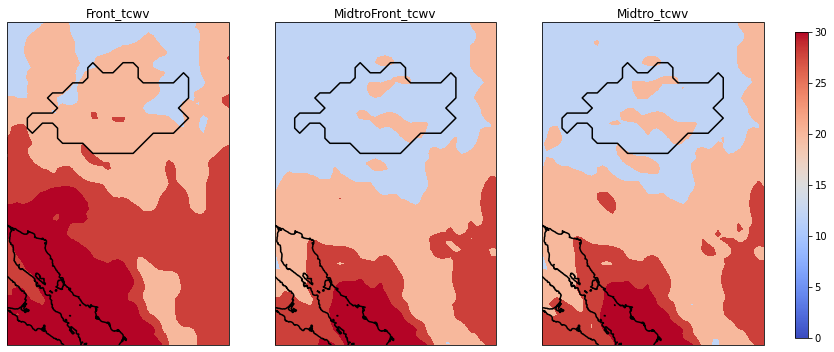

In [39]:
tcwv_front = tcwv.sel(time=front_days).mean(dim='time')
tcwv_midtro = tcwv.sel(time=midtro_days).mean(dim='time')
tcwv_midtro_front = tcwv.sel(time=midtro_front_days).mean(dim='time')
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(4)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
norm = colors.Normalize(vmin=0, vmax=30)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front.longitude, tcwv_front.latitude, tcwv_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm')
ax.set_title('Front_tcwv')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front.longitude, tcwv_midtro_front.latitude, tcwv_midtro_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm')
ax.set_title('MidtroFront_tcwv')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
ax.contourf(tcwv_front.longitude, tcwv_midtro.latitude, tcwv_midtro, transform=cartopy.crs.PlateCarree(), norm=norm, cmap='coolwarm')
ax.set_title('Midtro_tcwv')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

In [34]:
w500_front = w500.sel(time=front_days).mean(dim='time')
w500_midtro = w500.sel(time=midtro_days).mean(dim='time')
w500_midtro_front = w500.sel(time=midtro_front_days).mean(dim='time')
print(np.max(w500_front.data))
print(np.min(w500_front.data))

0.5656486
-1.0019709


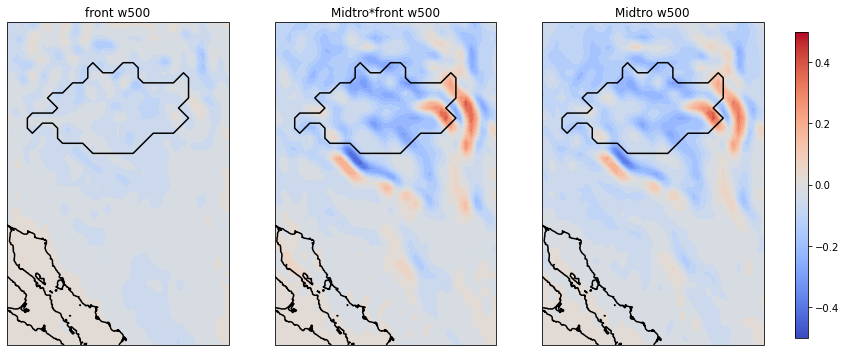

In [35]:
fig = plt.figure(figsize=(12, 5))
norm = colors.TwoSlopeNorm(vmin=-.5, vcenter=0, vmax=.5)
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_front, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm", levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_midtro_front, transform=cartopy.crs.PlateCarree(), cmap="coolwarm", norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro*front w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
ax.contourf(w500_midtro.longitude, w500_midtro.latitude, w500_midtro, transform=cartopy.crs.PlateCarree(), cmap="coolwarm", norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_title('Midtro w500')
ax.set_extent([-115, -104, 26, 42], crs=cartopy.crs.PlateCarree())
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.show()

# Sub3

In [52]:
sub_id = 3
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')

In [53]:
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
midtro_days = np.where(midtro_sub>0)[0]
midtro_days = sub_precip.time.data[midtro_days]
midtro_front_days = list(set(midtro_days).intersection(set(front_days)))
print(len(front_days))
print(len(midtro_days))
print(len(midtro_front_days))

200
122
27


In [54]:
midtro_wo_front = list(set(midtro_days).difference(set(front_days)))
print(sorted(midtro_wo_front))

[numpy.datetime64('1979-08-13T00:00:00.000000000'), numpy.datetime64('1979-08-14T00:00:00.000000000'), numpy.datetime64('1980-09-08T00:00:00.000000000'), numpy.datetime64('1980-09-09T00:00:00.000000000'), numpy.datetime64('1982-07-05T00:00:00.000000000'), numpy.datetime64('1982-09-11T00:00:00.000000000'), numpy.datetime64('1982-09-13T00:00:00.000000000'), numpy.datetime64('1982-09-27T00:00:00.000000000'), numpy.datetime64('1982-09-28T00:00:00.000000000'), numpy.datetime64('1982-09-29T00:00:00.000000000'), numpy.datetime64('1982-09-30T00:00:00.000000000'), numpy.datetime64('1983-06-02T00:00:00.000000000'), numpy.datetime64('1983-06-12T00:00:00.000000000'), numpy.datetime64('1983-09-29T00:00:00.000000000'), numpy.datetime64('1983-09-30T00:00:00.000000000'), numpy.datetime64('1984-07-23T00:00:00.000000000'), numpy.datetime64('1984-09-12T00:00:00.000000000'), numpy.datetime64('1985-06-25T00:00:00.000000000'), numpy.datetime64('1985-09-18T00:00:00.000000000'), numpy.datetime64('1985-09-19T0

# Sub6

In [55]:
sub_id = 6
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
midtro_days = np.where(midtro_sub>0)[0]
midtro_days = sub_precip.time.data[midtro_days]
midtro_front_days = list(set(midtro_days).intersection(set(front_days)))
print(len(front_days))
print(len(midtro_days))
print(len(midtro_front_days))

379
62
11


In [56]:
midtro_wo_front = list(set(midtro_days).difference(set(front_days)))
print(sorted(midtro_wo_front))

[numpy.datetime64('1979-06-04T00:00:00.000000000'), numpy.datetime64('1979-07-03T00:00:00.000000000'), numpy.datetime64('1979-08-13T00:00:00.000000000'), numpy.datetime64('1982-06-30T00:00:00.000000000'), numpy.datetime64('1982-07-01T00:00:00.000000000'), numpy.datetime64('1982-07-05T00:00:00.000000000'), numpy.datetime64('1982-07-06T00:00:00.000000000'), numpy.datetime64('1982-09-27T00:00:00.000000000'), numpy.datetime64('1982-09-28T00:00:00.000000000'), numpy.datetime64('1982-09-29T00:00:00.000000000'), numpy.datetime64('1982-09-30T00:00:00.000000000'), numpy.datetime64('1983-09-29T00:00:00.000000000'), numpy.datetime64('1983-09-30T00:00:00.000000000'), numpy.datetime64('1984-09-08T00:00:00.000000000'), numpy.datetime64('1984-09-21T00:00:00.000000000'), numpy.datetime64('1985-09-06T00:00:00.000000000'), numpy.datetime64('1985-09-10T00:00:00.000000000'), numpy.datetime64('1985-09-11T00:00:00.000000000'), numpy.datetime64('1985-09-12T00:00:00.000000000'), numpy.datetime64('1985-09-18T0

# Sub2

In [57]:
sub_id = 2
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
midtro_days = np.where(midtro_sub>0)[0]
midtro_days = sub_precip.time.data[midtro_days]
midtro_front_days = list(set(midtro_days).intersection(set(front_days)))
print(len(front_days))
print(len(midtro_days))
print(len(midtro_front_days))

117
42
6


In [58]:
midtro_wo_front = list(set(midtro_days).difference(set(front_days)))
print(sorted(midtro_wo_front))

[numpy.datetime64('1979-08-13T00:00:00.000000000'), numpy.datetime64('1980-09-09T00:00:00.000000000'), numpy.datetime64('1982-07-06T00:00:00.000000000'), numpy.datetime64('1982-09-12T00:00:00.000000000'), numpy.datetime64('1982-09-16T00:00:00.000000000'), numpy.datetime64('1982-09-17T00:00:00.000000000'), numpy.datetime64('1983-09-29T00:00:00.000000000'), numpy.datetime64('1983-09-30T00:00:00.000000000'), numpy.datetime64('1984-07-23T00:00:00.000000000'), numpy.datetime64('1984-09-25T00:00:00.000000000'), numpy.datetime64('1985-09-06T00:00:00.000000000'), numpy.datetime64('1985-09-18T00:00:00.000000000'), numpy.datetime64('1985-09-19T00:00:00.000000000'), numpy.datetime64('1985-09-28T00:00:00.000000000'), numpy.datetime64('1986-09-09T00:00:00.000000000'), numpy.datetime64('1986-09-23T00:00:00.000000000'), numpy.datetime64('1986-09-24T00:00:00.000000000'), numpy.datetime64('1990-09-21T00:00:00.000000000'), numpy.datetime64('1991-06-01T00:00:00.000000000'), numpy.datetime64('1992-08-23T0